In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
import warnings
warnings.filterwarnings('ignore')


In [42]:
# Define a function to get data given a list of tickers and clean the data
def get_tickers(filepath, start_date = "2014-01-01"):
    tickers = []
    with open(filepath) as file:
        for line in file:
            tickers.append(line.strip())
    data = yf.download(tickers, start = start_date).sort_index()['Adj Close']
    clean_data = data[data.isna().sum(axis = 1) != data.shape[1]]
    clean_data = clean_data.dropna(axis = 1)
    return clean_data

In [43]:
def get_worst_performing(stock_data, date, t, n):
    date = pd.to_datetime(date)
    df = stock_data.copy()[date-pd.DateOffset(days=10):date]
    return_df = df.pct_change(periods=t)[-1:]
    data_dict = return_df.to_dict(orient='records')[0]
    sorted_tickers = sorted(data_dict.items(), key = lambda x: x[1])
    return [x[0] for x in sorted_tickers[:n]]
    
def get_best_performing(stock_data, date, t, n):
    date = pd.to_datetime(date)
    df = stock_data.copy()[date-pd.DateOffset(days=10):date]
    return_df = df.pct_change(periods=t)[-1:]
    data_dict = return_df.to_dict(orient='records')[0]
    sorted_tickers = sorted(data_dict.items(), key = lambda x: x[1])
    return [x[0] for x in data_dict[-n:]]

In [44]:
def construct_portfolio(stock_data, start_date = "2021-01-01", end_date = "2023-12-15", percentage_of_all_stocks_to_buy = 0.1, long_short = False, t = 20, rebalance_period_days = 5):
    portfolio = pd.DataFrame(data = np.zeros([len(stock_data),len(stock_data.columns)]), index = stock_data.index, columns=stock_data.columns)
    num_stocks = int(stock_data.shape[1] // (1 / percentage_of_all_stocks_to_buy))
    weight = 1 / num_stocks if not long_short else 1 / (2* num_stocks)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    last_rebalance_date = start_date - pd.Timedelta(days=rebalance_period_days)
    for date in stock_data[start_date : end_date].index:
        if (date - last_rebalance_date).days >= rebalance_period_days:
            long_stocks = get_worst_performing(stock_data = stock_data, date = date, t = t, n = num_stocks)
            current_month = date.month
        for ticker in long_stocks:
            portfolio.loc[date, ticker] = weight
        if long_short:
            short_stocks = get_best_performing(stock_data = stock_data, date = date, t = t, n = num_stocks)    
            for ticker in short_stocks:
                portfolio.loc[date, ticker] = -weight
    return portfolio[start_date : end_date]
        

In [45]:
def backtest(stock_data, portfolio, index, start_date = "2021-01-01", end_date = "2023-12-15"):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    returns = pd.DataFrame(index = portfolio.index)
    return_df = (stock_data).pct_change().shift(-1)[start_date : end_date].dropna()
    returns["daily_returns"] = (return_df * portfolio).sum(axis=1)
    returns["cumulative_returns"] = (returns["daily_returns"] + 1).cumprod() - 1
    returns["cumulative_%_returns"] = (returns["cumulative_returns"]) * 100
    returns['index_returns'] = index.pct_change().shift(-1)
    returns["index_cumulative_returns"] = (returns["index_returns"] + 1).cumprod() - 1
    returns["index_cumulative_%_returns"] = (returns["index_cumulative_returns"]) * 100
    return returns

In [46]:
# Get the Data
filepath = './s&p500.txt'
index_ticker = "SPY"
stock_data = get_tickers(filepath)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-01-01 -> 2024-01-16)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2020-01-02         2020-01-02
End Period          2023-12-29         2023-12-29
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   46.31%             80.78%
CAGR﹪              6.8%               10.78%

Sharpe              0.53               0.72
Prob. Sharpe Ratio  85.46%             92.2%
Sortino             0.74               1.02
Sortino/√2          0.52               0.72
Omega               1.15               1.15

Max Drawdown        -34.1%             -37.08%
Longest DD Days     725                559

Gain/Pain Ratio     0.11               0.15
Gain/Pain (1M)      0.54               0.79

Payoff Ratio        0.86               0.78
Profit Factor       1.11           

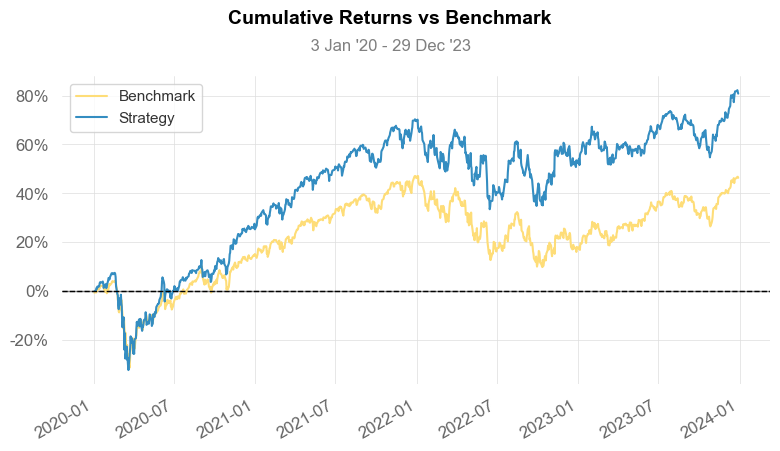

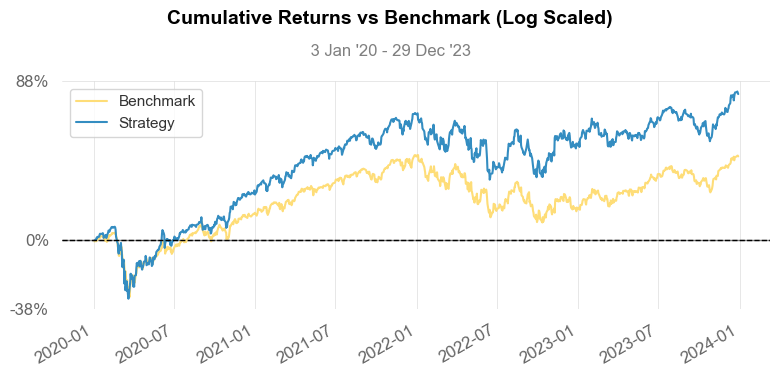

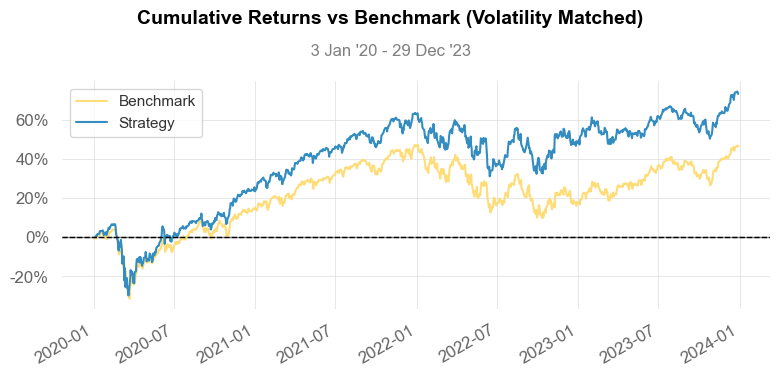

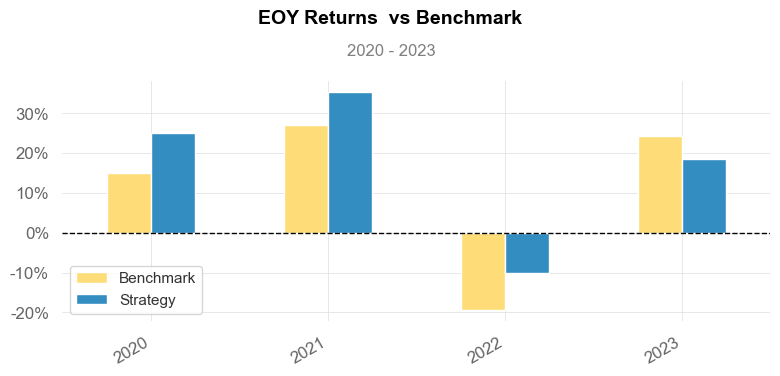

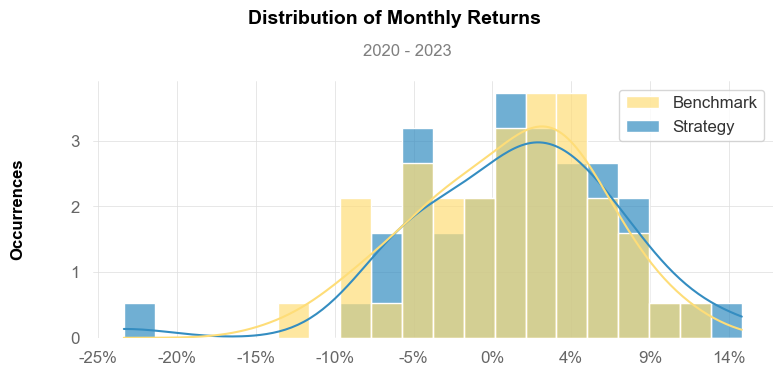

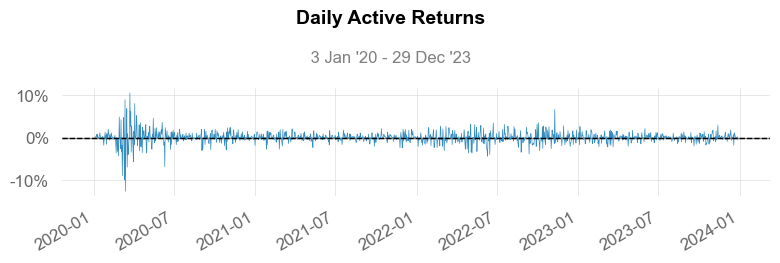

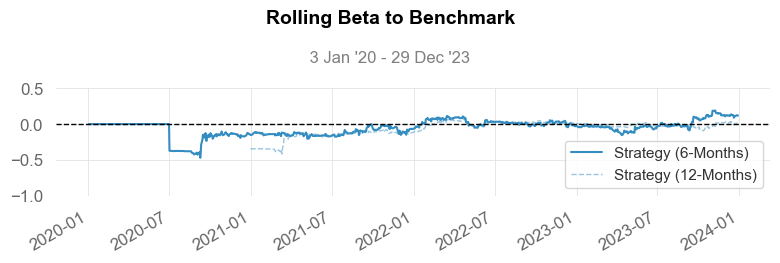

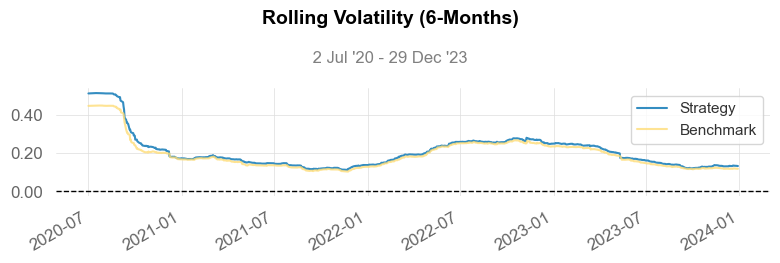

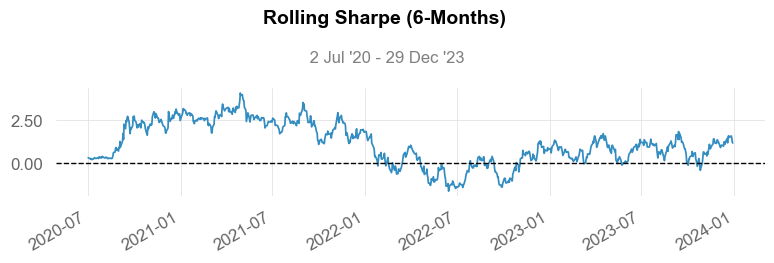

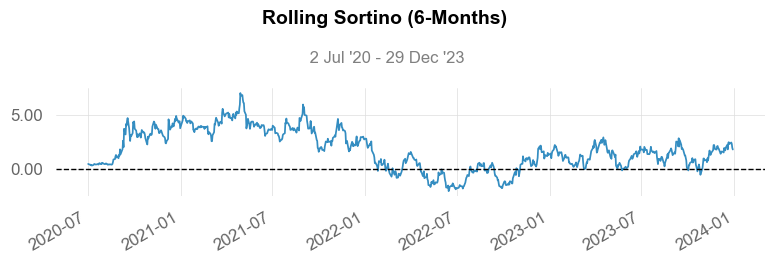

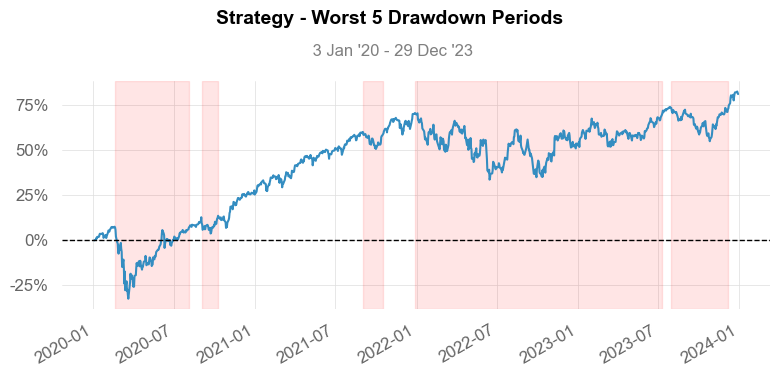

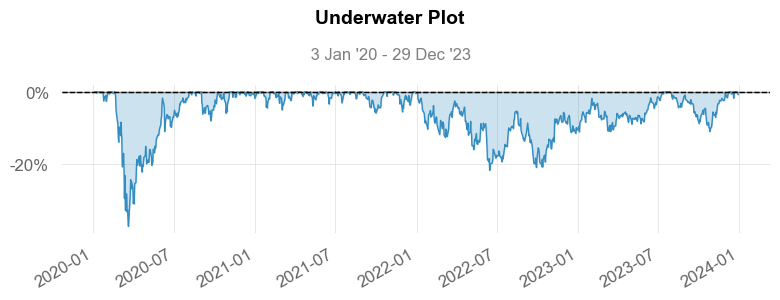

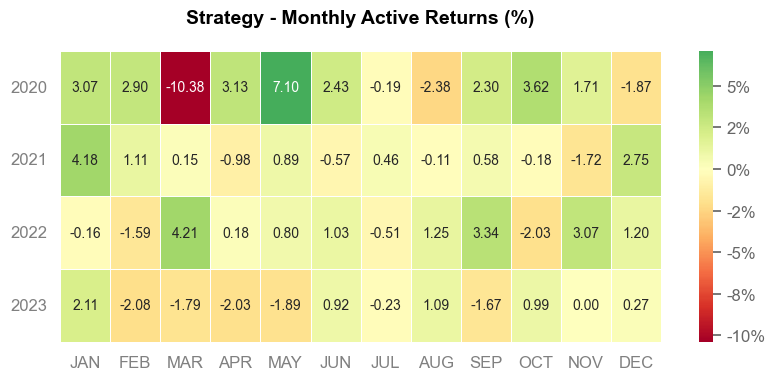

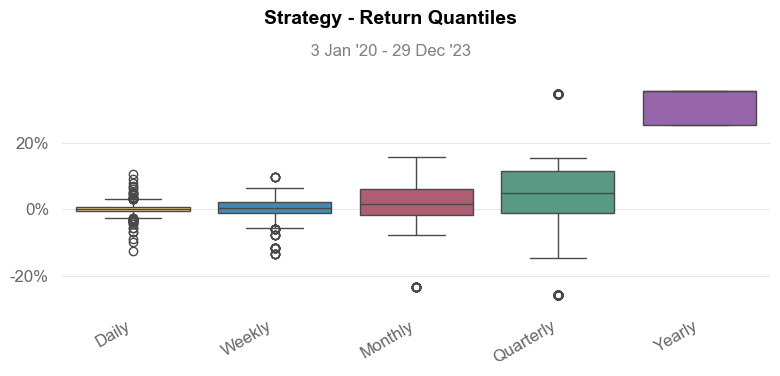

In [47]:
# ----------------------------------------------------------
# Set Parameters

# Lookback period
t = 20
# Rebalancing period
rebalance_every = 5
# Long-Short or Long-only
long_short = False
# ----------------------------------------------------------

# Run the strategy
start_date = "2020-01-01"
end_date = "2024-01-01"
index = yf.download(index_ticker, start_date, end_date)['Adj Close']
portfolio = construct_portfolio(stock_data, start_date = start_date, end_date = end_date, percentage_of_all_stocks_to_buy = 0.1, long_short = False, t = 20, rebalance_period_days = 5)
returns = backtest(stock_data, portfolio, index, start_date = start_date, end_date = end_date)
returns['daily_returns'].index = pd.to_datetime(returns['daily_returns'].index)
qs.reports.metrics(returns=returns['daily_returns'], 
                benchmark=index_ticker,
                mode = "basic", 
                title='Low Volatility Strategy vs. Index')
qs.reports.plots(returns=returns['daily_returns'], 
                benchmark=index_ticker,
                mode = "full",
                output='report.html')